# This notebook demonstrates how to read in and plot version 2.0 of the UMass FMCW data from VORTEX-SE 2016.
This version of the data have been reprocessed to reduce the impact of spurious power spikes from the high-voltage power supply in the UMass FMCW's TWT amplifier. In 2017 and subsequent seasons, the transmitter was upgraded to solid state, and this problem was no longer present.

The FMCW data are stored in NetCDF format. A great deal of analysis and visualization can be accomplished via the commonly-used <a href = "http://docs.xarray.dev">XArray</a> package for Python.

In [1]:
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# Plot a single file of UMass FMCW observations.
Each file contains approximately one hour of data.

In [2]:
path_to_files = './' # Adjust this path to match your system
fmcwFile = path_to_files + 'S20160307T180001.nc'

In [3]:
fmcw = xr.open_dataset(fmcwFile, decode_times = False)
# Convert timestamp to datetime64:
fmcw = fmcw.assign_coords(time = pd.to_datetime(fmcw.time.values, unit='s'))
fmcw.time.attrs = {'units' : 'UTC'}
fmcw # Print contents of this file

<xarray.Dataset>
Dimensions:  (time: 207, vels: 256, gate: 1024)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-07T18:00:01 ... 2016-03-07T18:59:59
  * vels     (vels) float32 -4.899 -4.861 -4.822 -4.784 ... 4.784 4.822 4.861
  * gate     (gate) float32 1.0 5.0 10.0 15.0 ... 5.105e+03 5.11e+03 5.115e+03
Data variables: (12/15)
    Zef      (time, gate, vels) int16 ...
    sf       (time, gate, vels) int16 ...
    sn       (time, gate) int16 ...
    sff      (time, gate, vels) int16 ...
    snr      (time, gate) int16 ...
    Ze       (time, gate) int16 ...
    ...       ...
    sfp      (time, gate, vels) int16 ...
    Zec      (time, gate) int16 ...
    vec      (time, gate) float32 ...
    snc      (time, gate) int16 ...
    ncp      (time, gate) float32 ...
    ablh     (time) float64 ...
Attributes:
    NetCDFRevision:  UMass MIRSL and Purdue FMCW v2.0
    RadarName:       UMa-FMCW
    PRF:             190.735
    Frequency:       2920000000.0
    Latitude:        34.6906
    Longitude:       -86.8815

Plot coherent reflectivity (Zec)

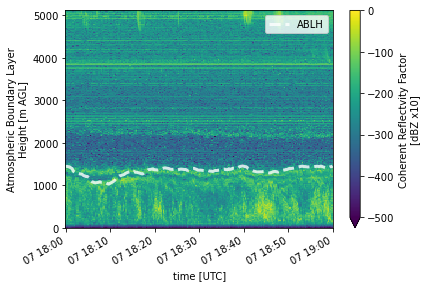

In [4]:
fmcw.Zec.plot(x = 'time', cmap = 'viridis', vmin = -500, vmax = 0)
fmcw.ablh.plot.line(color = 'white', linestyle = '--', alpha = 0.8, lw = 3, label = 'ABLH')
plt.legend();

Plot Doppler velocity

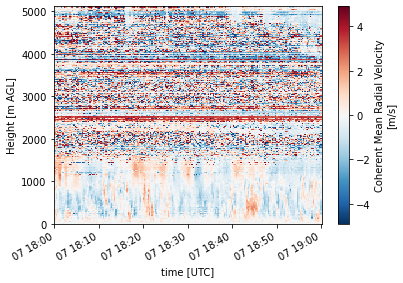

In [5]:
fmcw.vec.plot(x='time')

Threshold Doppler velocity on another variable, in this case, coherent signal-to-noise ratio (snc) < -10 dB. Zoom in on boundary layer to see updrafts and downdrafts more clearly.

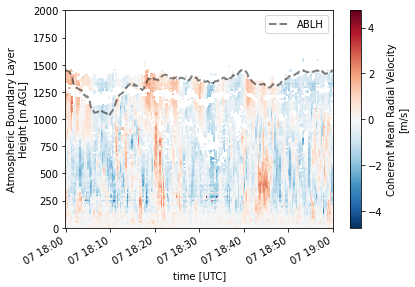

In [6]:
fmcw.vec.where(fmcw.snc > -10).plot(x = 'time')
fmcw.ablh.plot.line(color = 'black', linestyle = '--', lw = 2, alpha = 0.5, label = 'ABLH')
plt.ylim(0,2000);
plt.legend();

# Plot Doppler spectra at a particular time

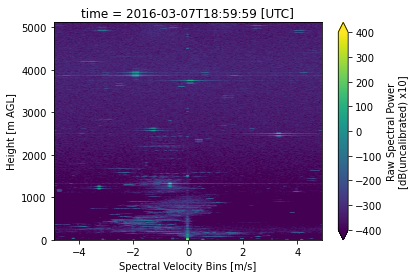

In [7]:
fmcw.sf.loc["2016-03-07T18:59:59"].plot(cmap = 'viridis', vmin = -400, vmax = 400)

# Plot raw, median filtered, and in-painted spectra together

Text(0.5, 0.98, '2016-03-07 18:59:59')

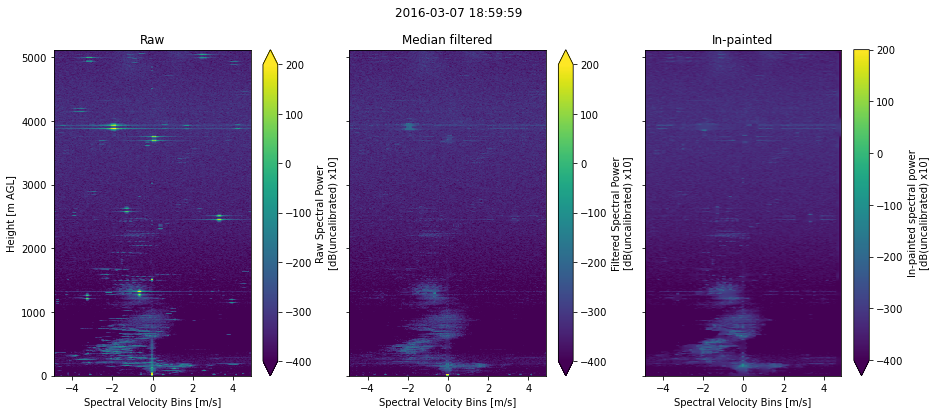

In [8]:
# Plot different versions of the same spectra
timeStr = "2016-03-07T18:59:59"
fig, axs = plt.subplots(ncols = 3, sharey = True, figsize = (15, 6))
fmcw.sf.loc[timeStr].plot(ax = axs[0], cmap = 'viridis', vmin = -400, vmax = 200)
axs[0].set_title('Raw');
fmcw.sff.loc[timeStr].plot(ax = axs[1], cmap = 'viridis', vmin = -400, vmax = 200)
axs[1].set_title('Median filtered');
axs[1].set_ylabel(None)
fmcw.sfp.loc[timeStr].plot(ax = axs[2], cmap = 'viridis', vmin = -400, vmax = 200)
axs[2].set_title('In-painted');
axs[2].set_ylabel(None)
plt.suptitle(timeStr.replace("T"," "))

# Plot time series of ABLH height on top of reflectivity; opening multiple files at once

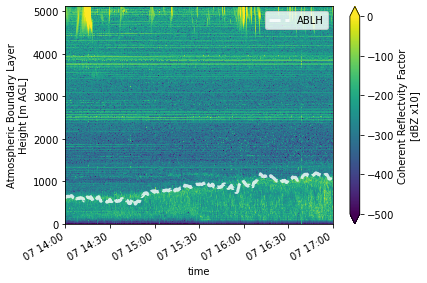

In [9]:
fmcw_mf = xr.open_mfdataset(path_to_files + "/*.nc", decode_times = False, preprocess = lambda x: x.assign_coords(time = pd.to_datetime(x.time.values, unit='s')))
fmcw_mf.Zec.sel(time = slice("2016-03-07 14:00:00", "2016-03-07 17:00:00")).plot(x = 'time', cmap = 'viridis', vmin = -500, vmax = 0)
fmcw_mf.ablh.sel(time = slice("2016-03-07 14:00:00", "2016-03-07 17:00:00")).plot.line(color = 'white', linestyle = '--', alpha = 0.8, lw = 3, label = 'ABLH')
plt.legend();

In [10]:
# Close files to clean up memory
fmcw.close()
fmcw_mf.close()